# Precision Audio Anomaly Detection
In this project, I take data from MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection. This dataset is not as commonly used as other datasets and creates an opportunity to perform a unique analysis.

Data was downloaded from https://zenodo.org/records/3384388 in the form of audio files. 0_dB_fan.zip was downloaded and the audio files were extracted into the working folder. Audio features were obtained from the audio files using librosa.

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

In [3]:
# Functions to be used in the following code

def plot_waveform_and_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load at native sample rate
    
    plt.figure(figsize=(14, 5))

    # Plot waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

    # Plot mel spectrogram
    plt.subplot(1, 2, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")

    plt.tight_layout()
    plt.show()

# for simplicty, cosider 3 features 
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)       # Mel-frequency cepstral coefficients, detect subtle operational tone changes 
    zcr = librosa.feature.zero_crossing_rate(y)               # measure noisiness, mechanical vibration
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # energy shifts in faulty equipment
    return np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(zcr),
        np.mean(centroid),
        sr
    ])

def get_metrics(name, y_true, y_pred, y_proba):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

C:\Users\Verl\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Verl\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Verl\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


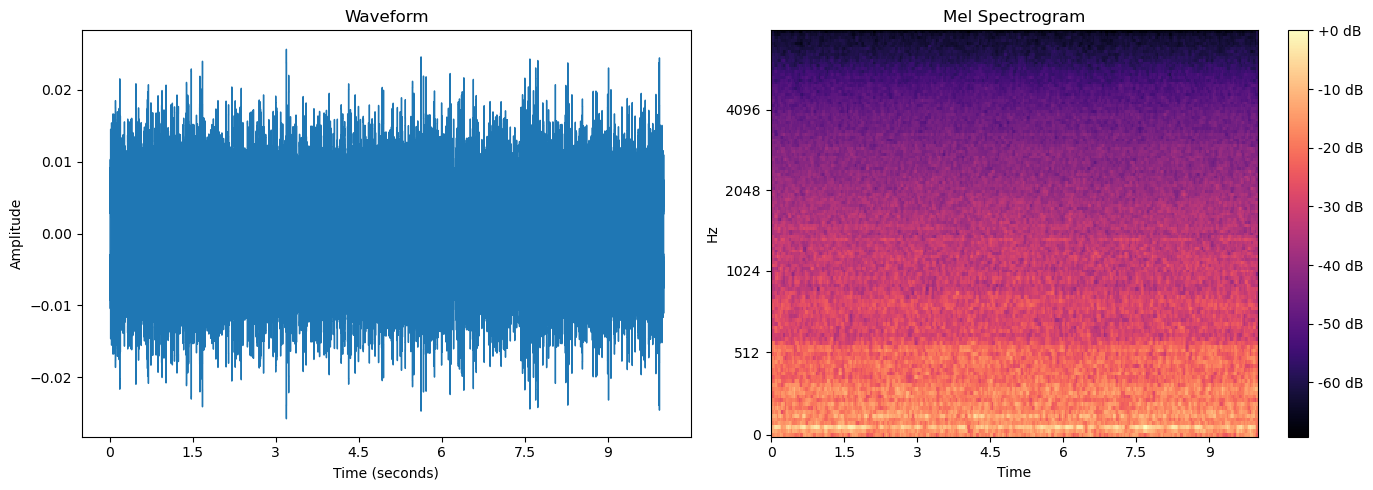

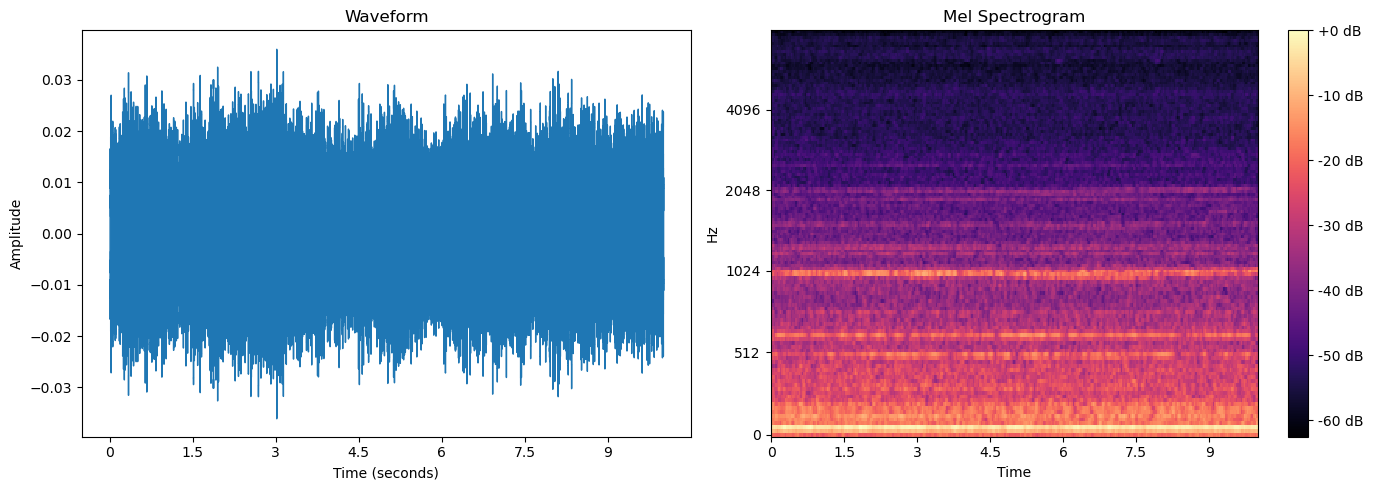

In [4]:
# Checking a couple samples to visually inspect audio data 

file_normal = os.path.normpath("./fan/id_00/normal/00000000.wav")
file_abnormal = os.path.normpath("./fan/id_00/abnormal/00000000.wav")

plot_waveform_and_spectrogram(file_normal)
plot_waveform_and_spectrogram(file_abnormal)

In [5]:
# using data on 1 fan, will use second fan later for comparison
base_dir = "./fan/id_00"
categories = ['normal', 'abnormal']

data = []

# For audio data, we would normally want to slice the data into samples of uniform length for analysis
# This dataset includes data the has been categorized based on a 10 second clip
# Segmenting would confuse the model as the anomoly might be in 1 segment but not another

for label in categories:
    folder = os.path.normpath(os.path.join(base_dir, label))
    print(folder)
    for file_name in tqdm(os.listdir(folder), desc=f"Processing {label}"):
        if not file_name.endswith(".wav"):
            continue
        file_path = os.path.join(folder, file_name)
        try:                                              # Error could be bad file or bug
            features = extract_features(file_path)
            data.append({
                'file': file_name,
                'label': 0 if label == 'normal' else 1,
                **{f'mfcc_{i+1}': val for i, val in enumerate(features[:13])},
                'zcr': features[13],
                'centroid': features[14],
                'sample_rate': features[15]
            })
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

df = pd.DataFrame(data)
print(df.head())

fan\id_00\normal


Processing normal: 100%|███████████████████████████████████████████████████████████| 1011/1011 [00:22<00:00, 44.44it/s]


fan\id_00\abnormal


Processing abnormal: 100%|███████████████████████████████████████████████████████████| 407/407 [00:09<00:00, 44.52it/s]


           file  label      mfcc_1      mfcc_2     mfcc_3     mfcc_4  \
0  00000000.wav      0 -390.064850  142.685455  -8.089349  32.070492   
1  00000001.wav      0 -378.171478  130.619019  -5.543435  31.267815   
2  00000002.wav      0 -354.077820  118.689659  -4.140584  18.339283   
3  00000003.wav      0 -374.678162  112.357193  14.614851  13.588820   
4  00000004.wav      0 -376.949615  129.354233  -6.963022  29.517775   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8    mfcc_9   mfcc_10   mfcc_11  \
0 -0.010225  13.652123 -2.965383  2.508208 -1.903253  2.109554 -0.497926   
1 -0.506159  13.796819 -2.709137  4.862411 -1.692594  2.185872 -1.560902   
2 -2.796698  10.823622 -1.264327  3.523583 -1.983617  2.963972 -1.129989   
3  3.869494   6.087846 -2.295030  1.982968  1.018534  4.018413  7.315485   
4 -3.731527  10.509781 -0.844754  3.724533 -3.259204 -3.215414 -2.958570   

    mfcc_12   mfcc_13       zcr     centroid  sample_rate  
0  1.280934  1.209655  0.054076  1011.275344      

In [6]:
# Verify sample rate is constant

unique_srs = df['sample_rate'].unique()
print("Unique sample rates found:", unique_srs)

if len(unique_srs) == 1:
    print(f"All files have consistent sample rate: {unique_srs[0]} Hz")
else:
    print("Warning: Multiple sample rates detected!")

Unique sample rates found: [16000.]
All files have consistent sample rate: 16000.0 Hz


Class distribution:
 label
0    1011
1     407
Name: count, dtype: int64


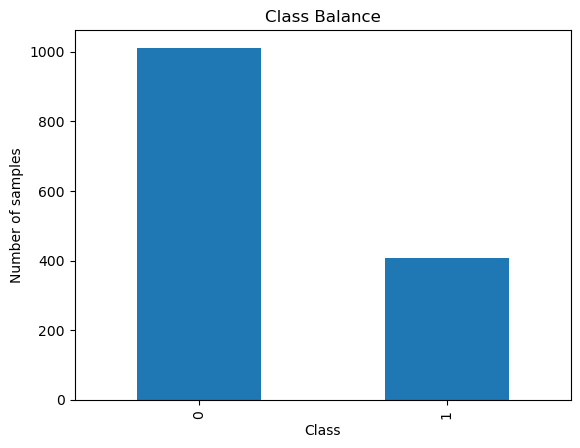

In [7]:
# Checking class balance, may need to use rebalancing techniques

class_counts = df['label'].value_counts()
print("Class distribution:\n", class_counts)

class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

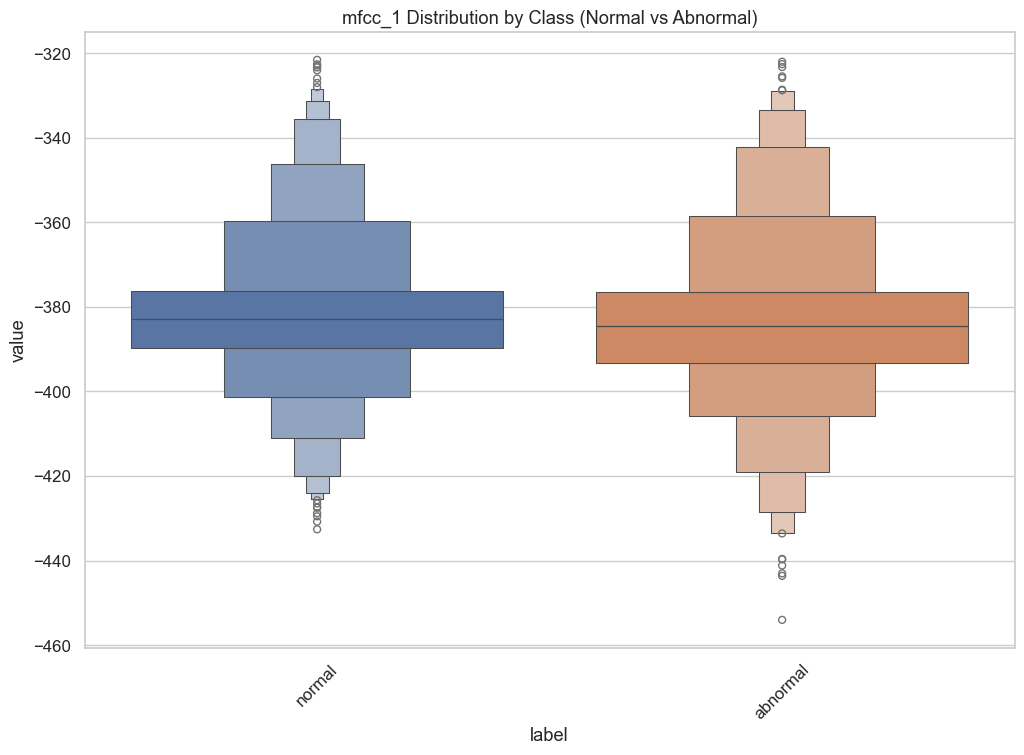

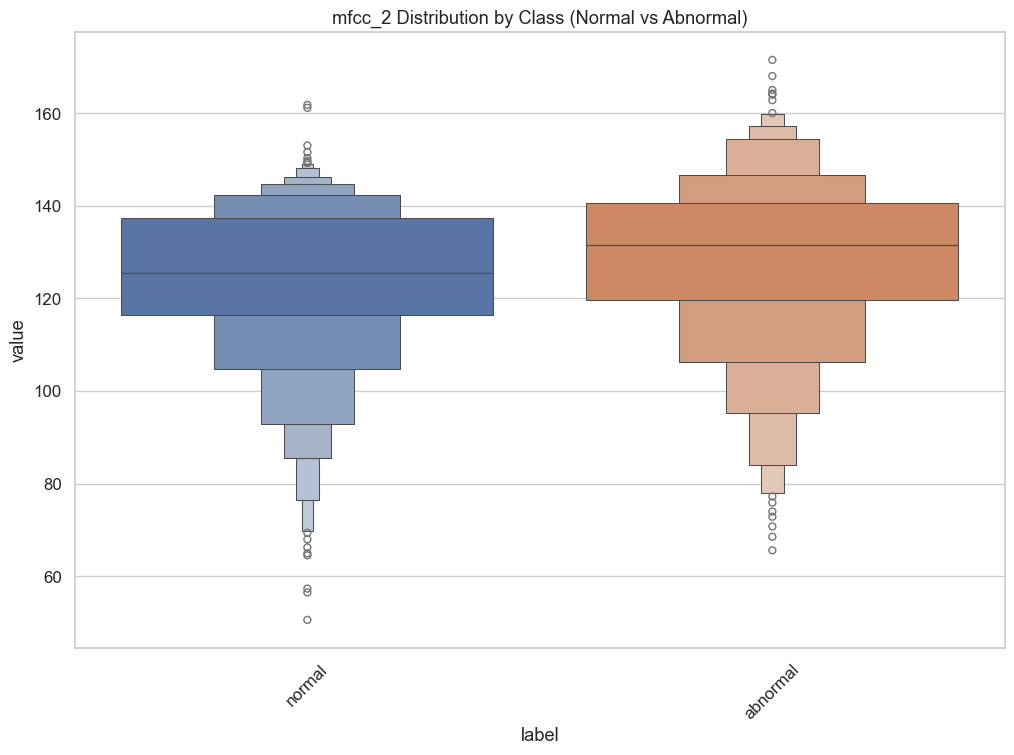

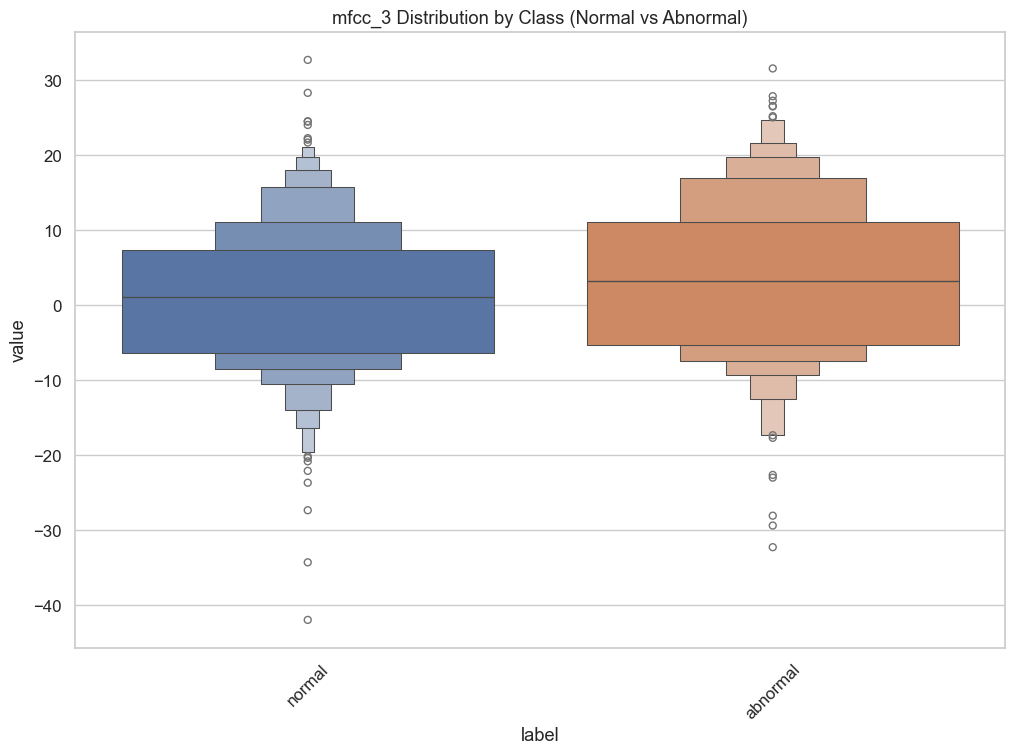

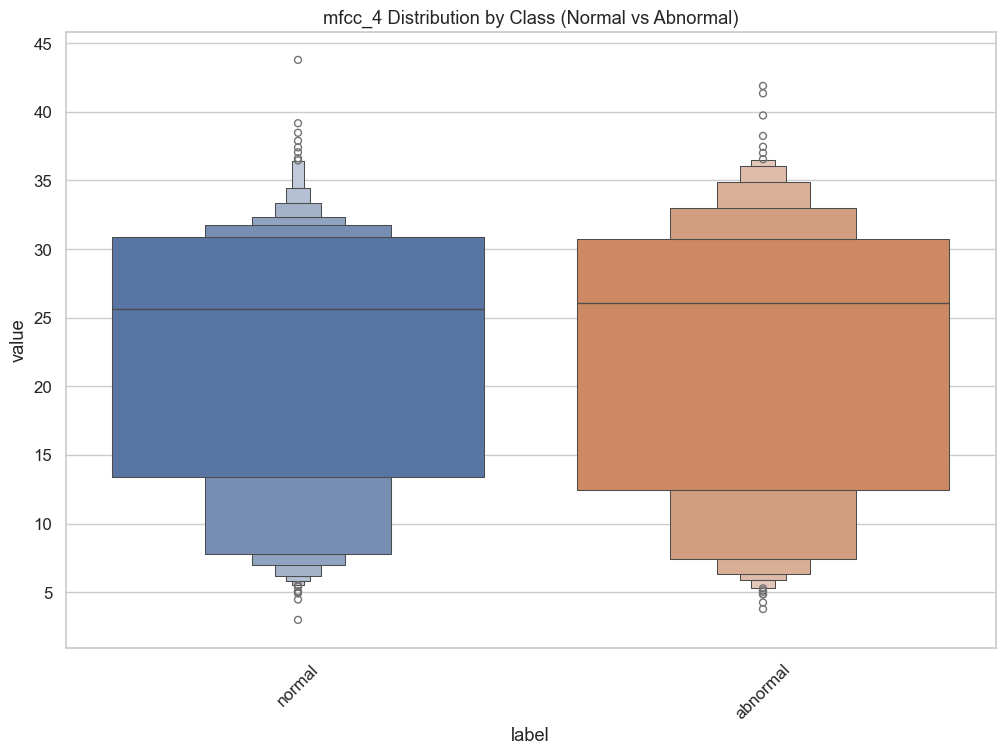

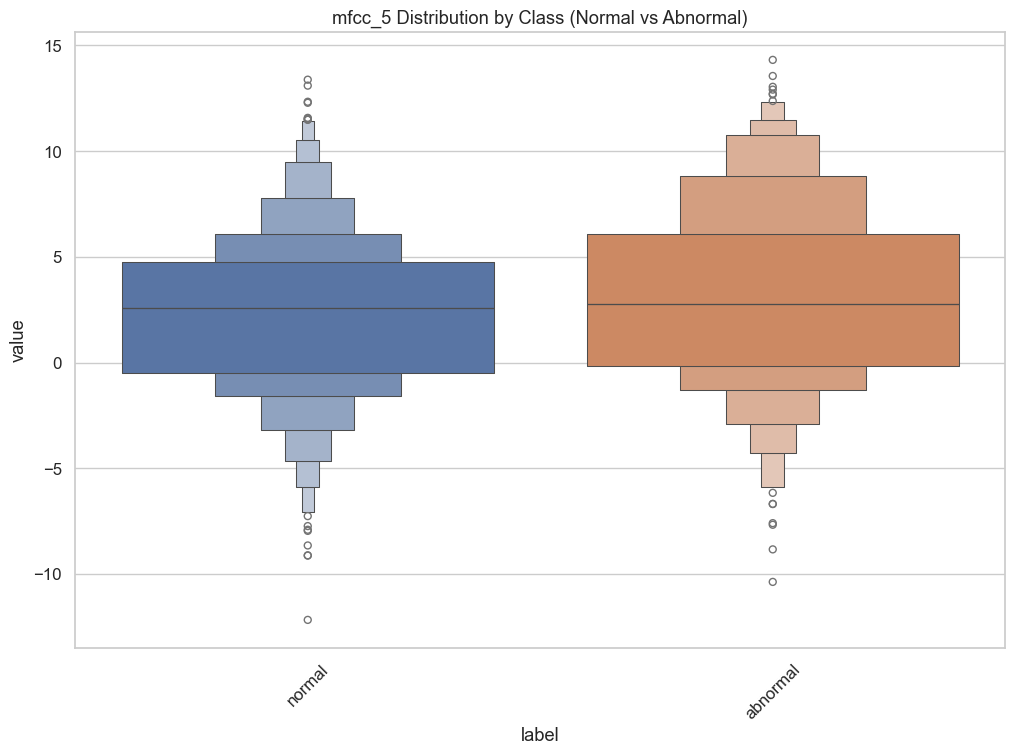

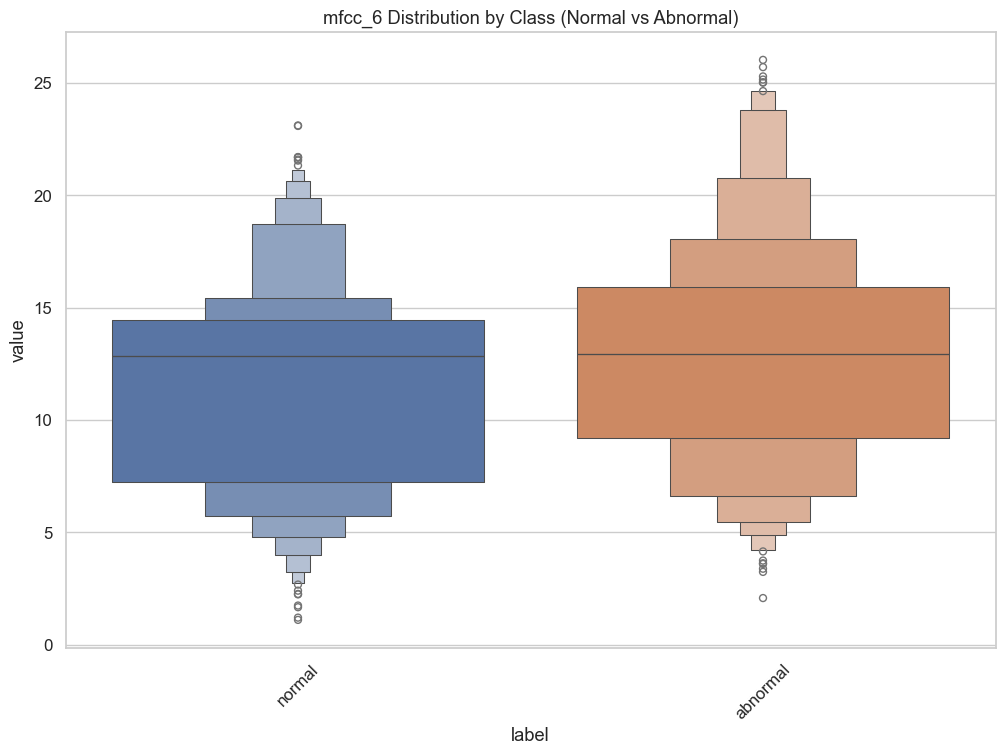

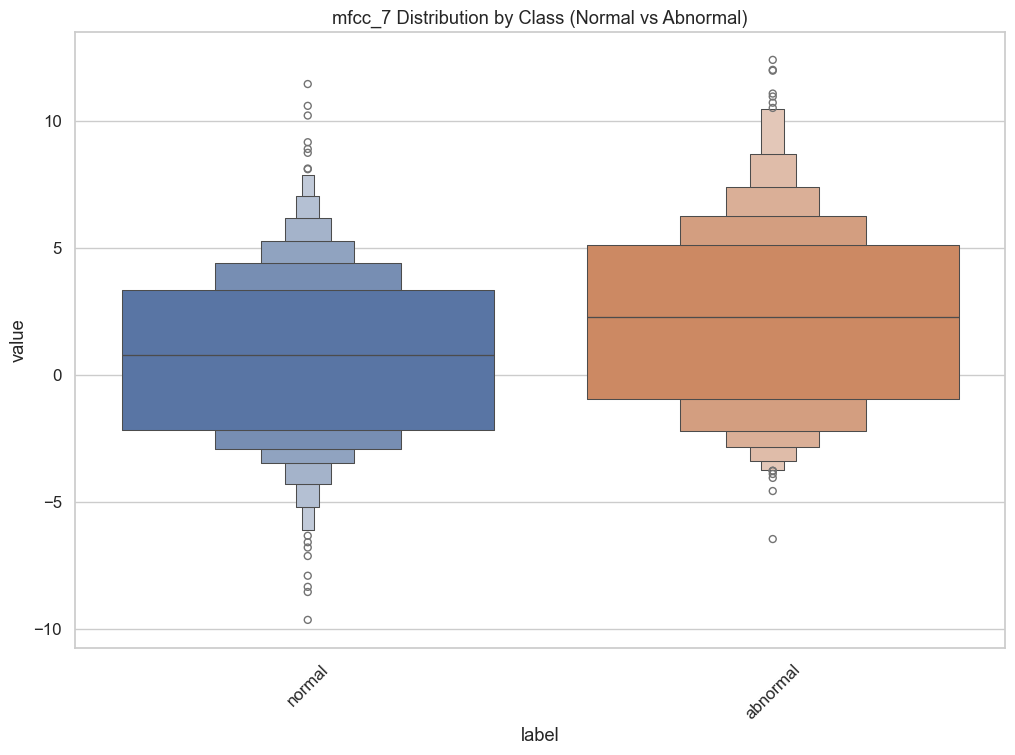

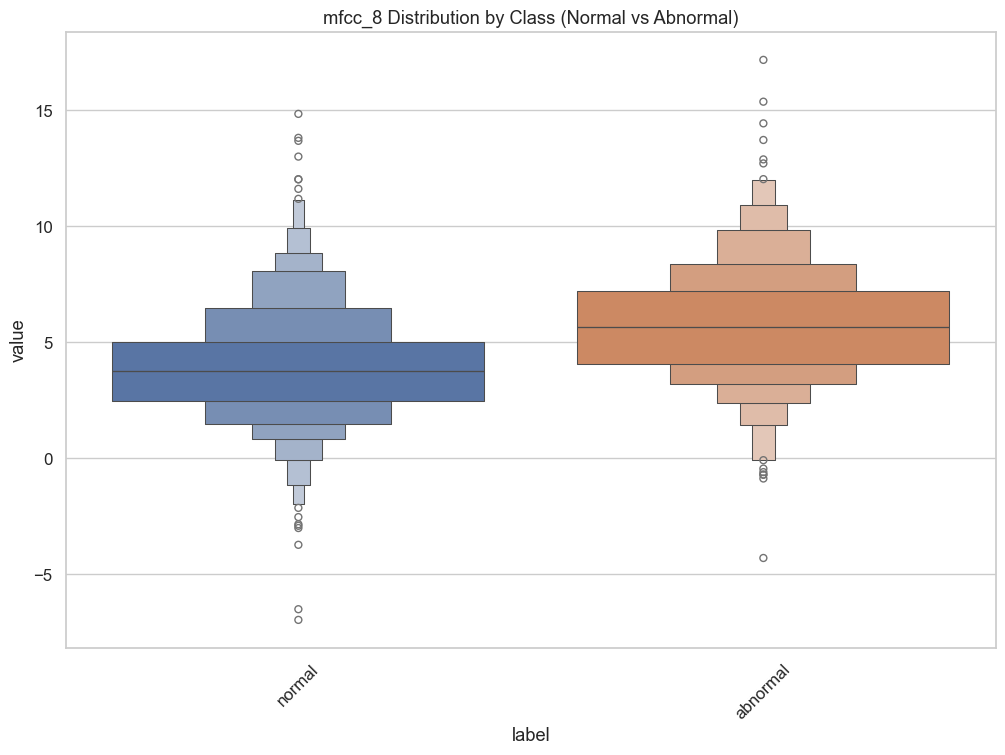

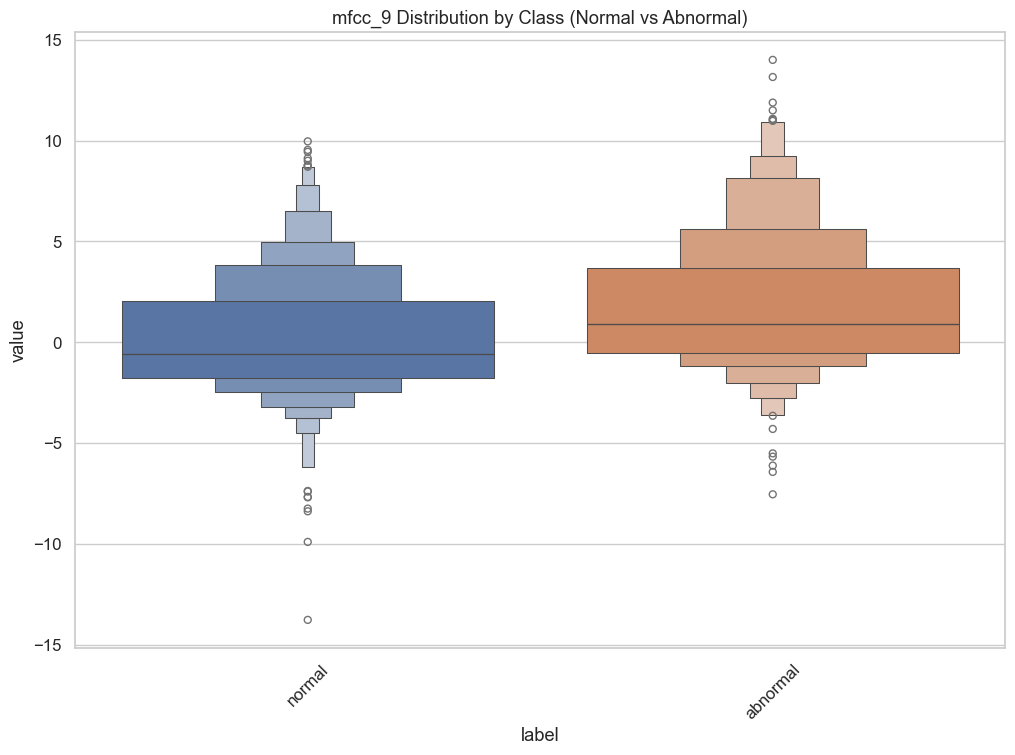

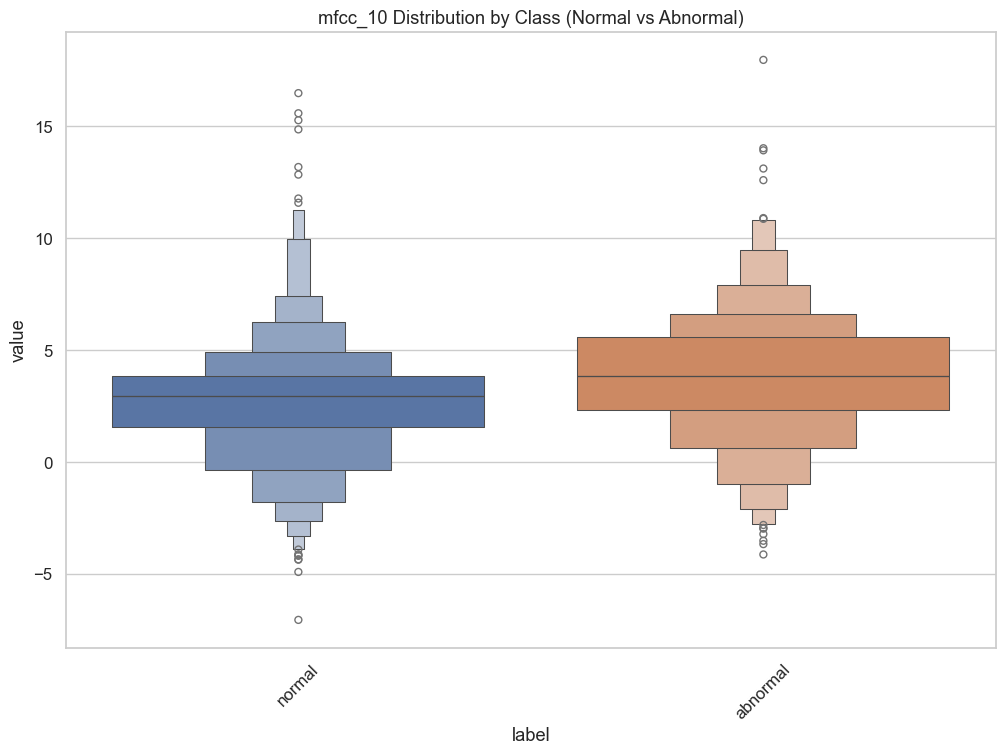

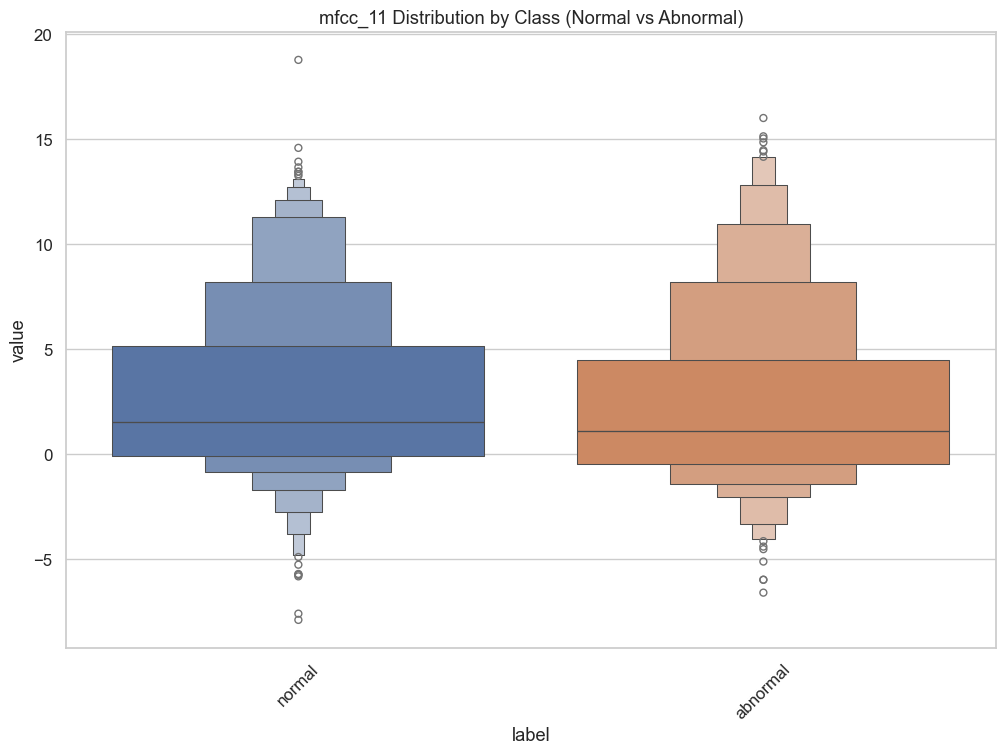

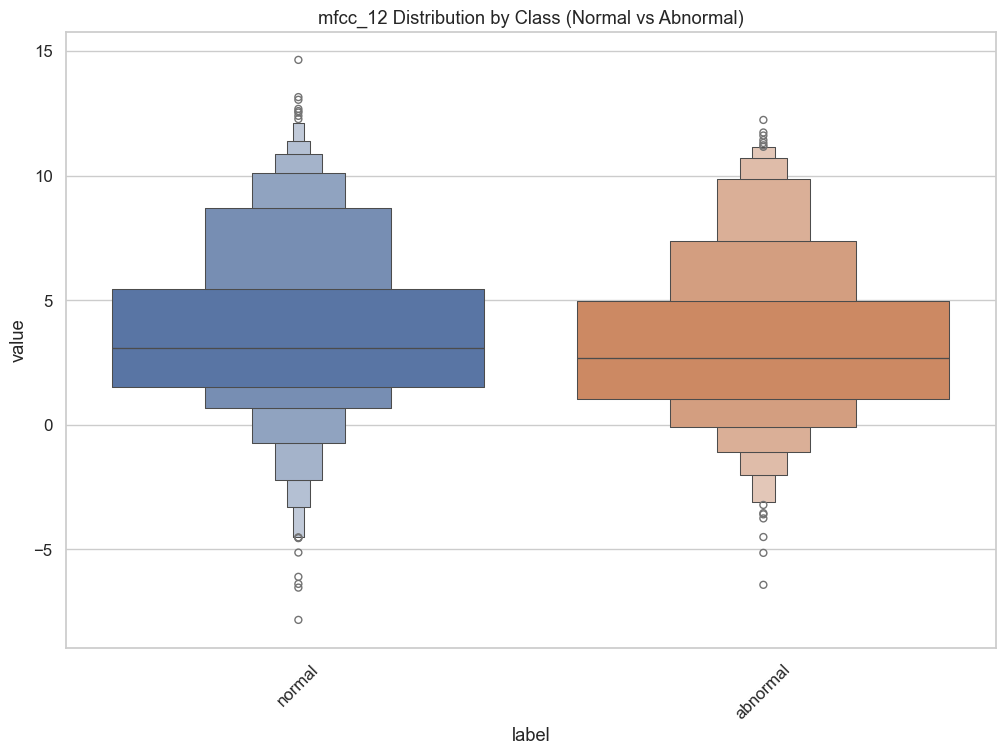

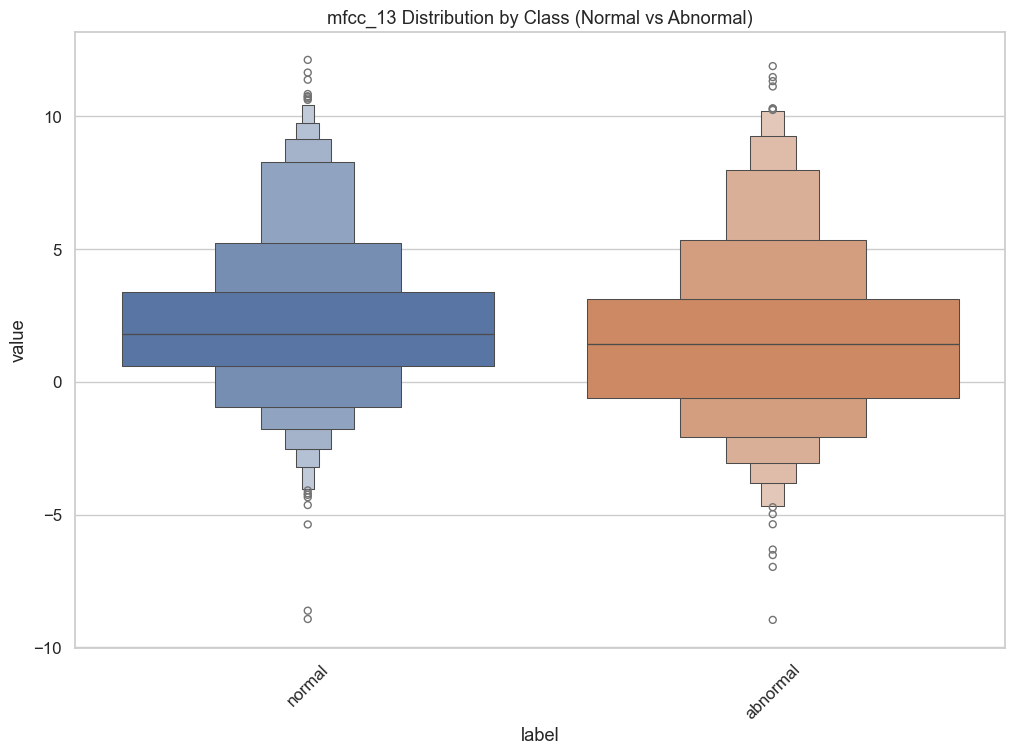

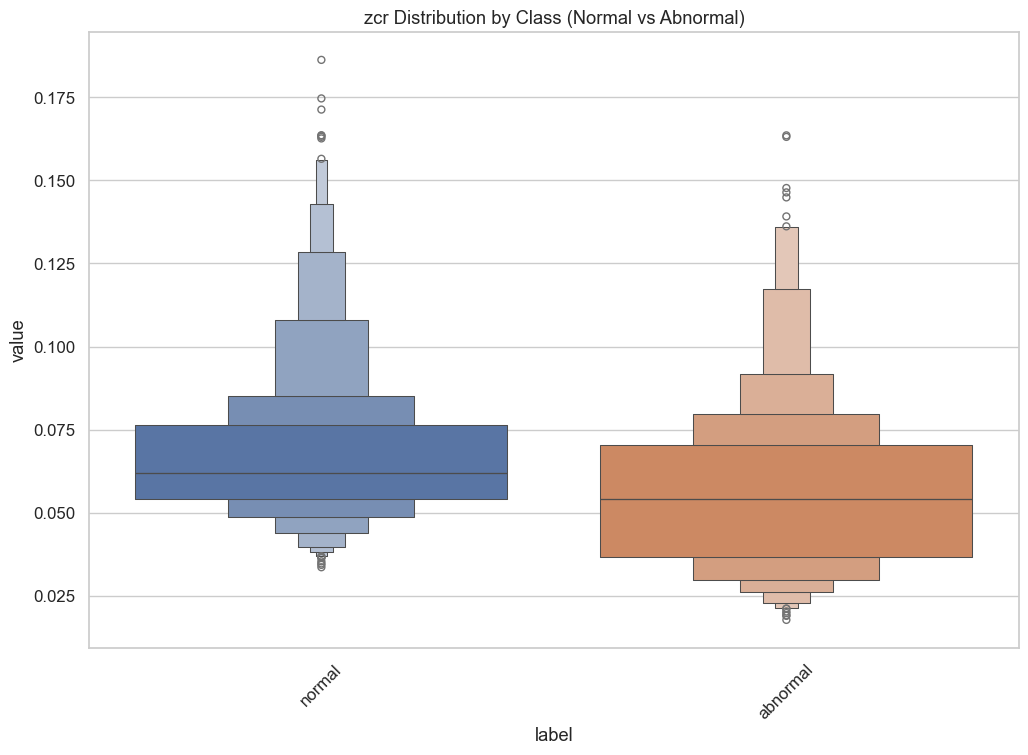

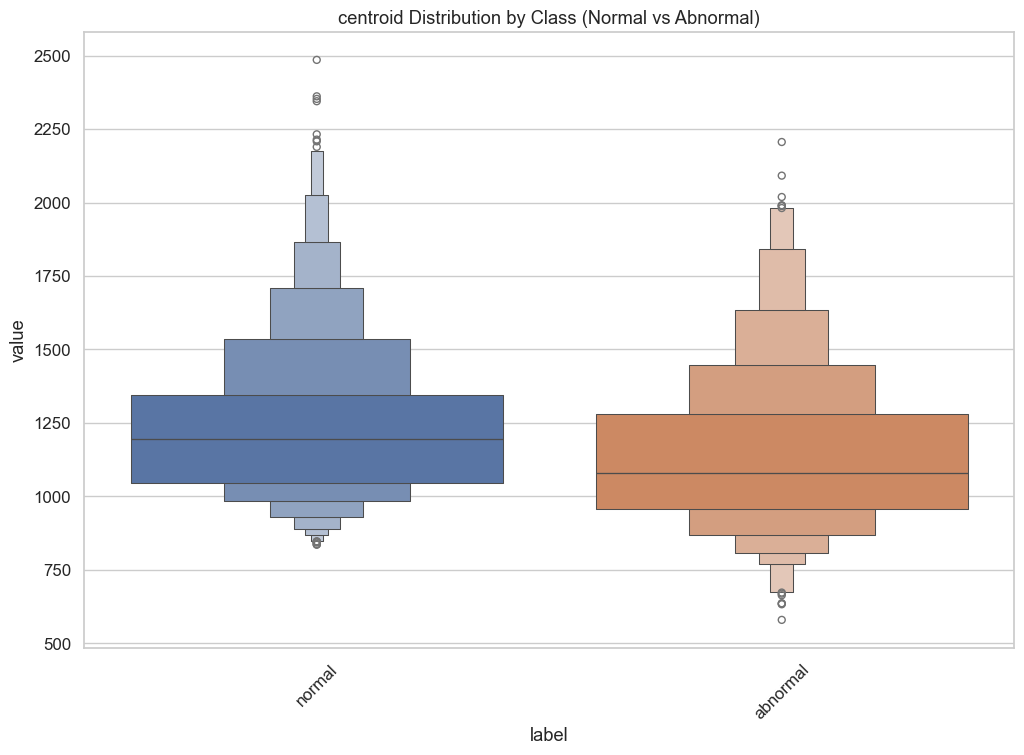

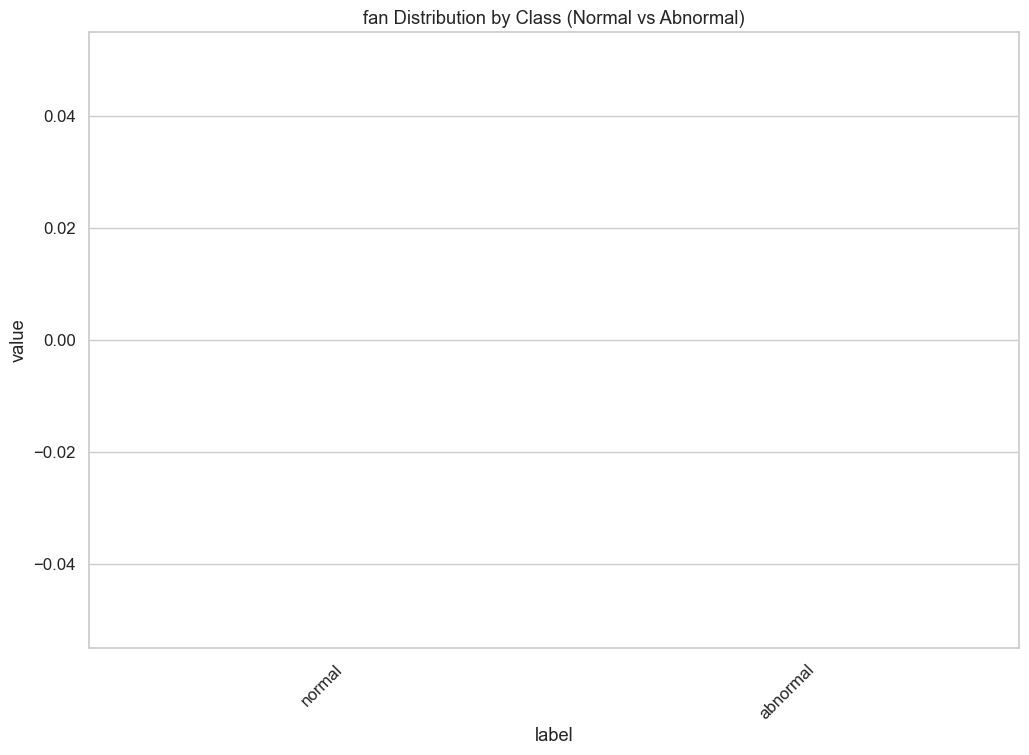

In [24]:
feature_cols = [col for col in df.columns if col not in ['label', 'file', 'sample_rate']]
df_melted = df.melt(id_vars='label', value_vars=feature_cols, var_name='feature', value_name='value')

df_melted['label'] = df_melted['label'].apply(lambda x: 'normal' if x == 0 else 'abnormal')
df_melted['value'] = pd.to_numeric(df_melted['value'], errors='coerce')

for feature in feature_cols:
    plt.figure(figsize=(12, 8))
    sns.boxenplot(x='label', y='value', hue='label', data=df_melted[df_melted['feature'] == feature])
    
    plt.xticks(rotation=45)
    plt.title(f'{feature} Distribution by Class (Normal vs Abnormal)')
    plt.show()

In [9]:
X = df.drop(columns=['label', 'file', 'sample_rate'])
y = df['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test, X_train_unscaled, X_test_unscaled = train_test_split(X_scaled, y, X, stratify=y, test_size=0.2, random_state=42)
# Need unscaled version of X for misclassification analysis

In [10]:
# Start with unbalanced Logistic Regression
lr_unbalanced = LogisticRegression(max_iter=1000, random_state=42)
lr_unbalanced.fit(X_train, y_train)
y_pred_lr_unbal = lr_unbalanced.predict(X_test)
y_prob_lr_unbal = lr_unbalanced.predict_proba(X_test)[:, 1]

In [11]:
# Balanced Logistic Regression
lr_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_balanced.fit(X_train, y_train)
y_pred_lr_bal = lr_balanced.predict(X_test)
y_prob_lr_bal = lr_balanced.predict_proba(X_test)[:, 1]

In [12]:
# unbalance Random Forest
rf_unbalanced = RandomForestClassifier(random_state=42)
rf_unbalanced.fit(X_train, y_train)
y_pred_rf_unbal = rf_unbalanced.predict(X_test)
y_prob_rf_unbal = rf_unbalanced.predict_proba(X_test)[:, 1]

In [13]:
# balanced Random Forest
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred_rf_bal = rf_balanced.predict(X_test)
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]

In [14]:
# inclduing SMOTE oversampling for comparison
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_resampled, y_resampled)
y_pred_lr_smote = lr_smote.predict(X_test)
y_prob_lr_smote = lr_smote.predict_proba(X_test)[:, 1]

rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_resampled, y_resampled)
y_pred_rf_smote = rf_smote.predict(X_test)
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

In [15]:
# getting metrics from each model so that we can compare
results = []

results.append(get_metrics("Logistic Unbalanced", y_test, y_pred_lr_unbal, y_prob_lr_unbal))
results.append(get_metrics("Random Forest Unbalanced", y_test, y_pred_rf_unbal, y_prob_rf_unbal))
results.append(get_metrics("Logistic Balanced", y_test, y_pred_lr_bal, y_prob_lr_bal))
results.append(get_metrics("Random Forest Balanced", y_test, y_pred_rf_bal, y_prob_rf_bal))
results.append(get_metrics("Logistic SMOTE", y_test, y_pred_lr_smote, y_prob_lr_smote))
results.append(get_metrics("Random Forest SMOTE", y_test, y_pred_rf_smote, y_prob_rf_smote))

results_df = pd.DataFrame(results).set_index('Model').round(3)

results_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Unbalanced,0.873,0.897,0.634,0.743,0.867
Random Forest Unbalanced,0.891,0.947,0.659,0.777,0.954
Logistic Balanced,0.803,0.627,0.780,0.696,0.868
Random Forest Balanced,0.898,0.982,0.659,0.788,0.948
Logistic SMOTE,0.796,0.618,0.768,0.685,0.866
Random Forest SMOTE,0.915,0.914,0.780,0.842,0.947


In [16]:
# Since we are looking at anomolous data, consider an unsupervised model
iso = IsolationForest(contamination=len(y_train[y_train==1]) / len(y_train), random_state=42)
iso.fit(X_train)

y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1) # recategorize abnormal as 1, normal as 0
y_scores_iso = -iso.decision_function(X_test) 

results.append(get_metrics("Isolation Forest", y_test, y_pred_iso, y_scores_iso))

results_df = pd.DataFrame(results).set_index('Model').round(3)

results_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Unbalanced,0.873,0.897,0.634,0.743,0.867
Random Forest Unbalanced,0.891,0.947,0.659,0.777,0.954
Logistic Balanced,0.803,0.627,0.780,0.696,0.868
Random Forest Balanced,0.898,0.982,0.659,0.788,0.948
Logistic SMOTE,0.796,0.618,0.768,0.685,0.866
Random Forest SMOTE,0.915,0.914,0.780,0.842,0.947
Isolation Forest,0.694,0.468,0.439,0.453,0.676


In [17]:
# The Random Forest SMOTE model has the best accuracy, recall, and F1 Score as well as high precision and ROC AUC

confusion_matrix(y_test, y_pred_rf_smote)

array([[196,   6],
       [ 18,  64]], dtype=int64)

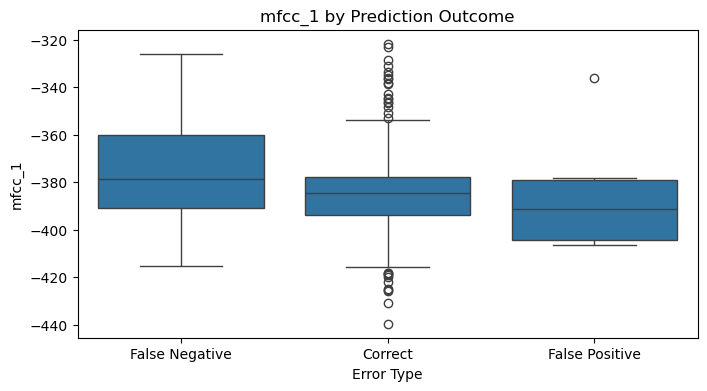

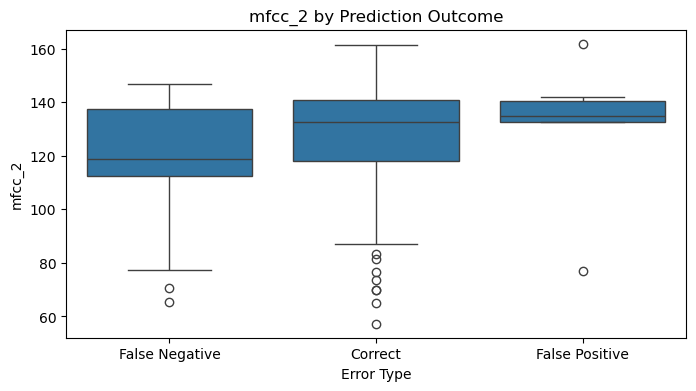

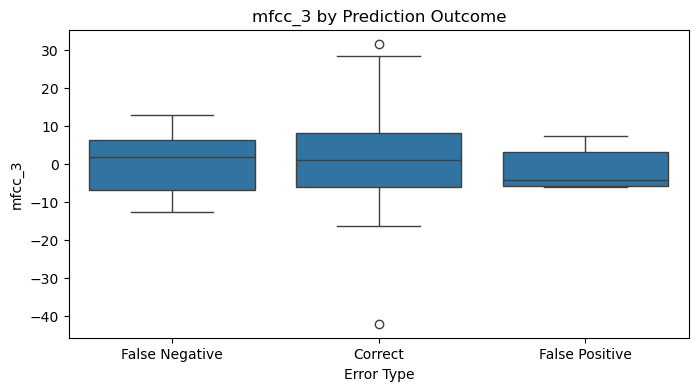

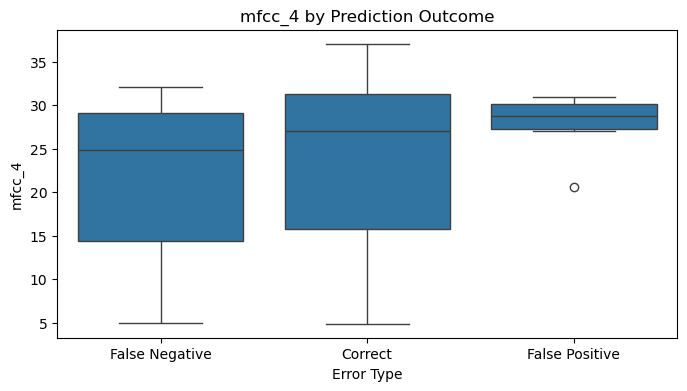

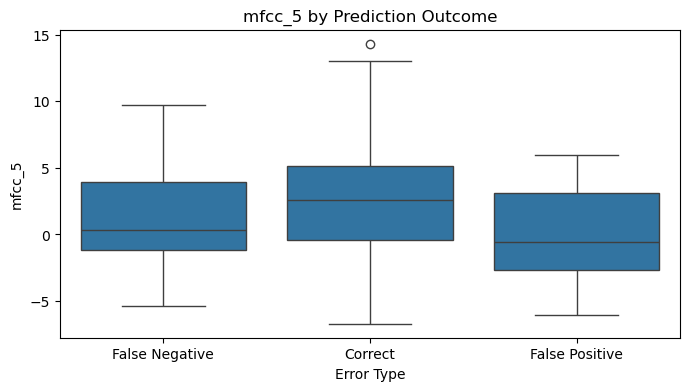

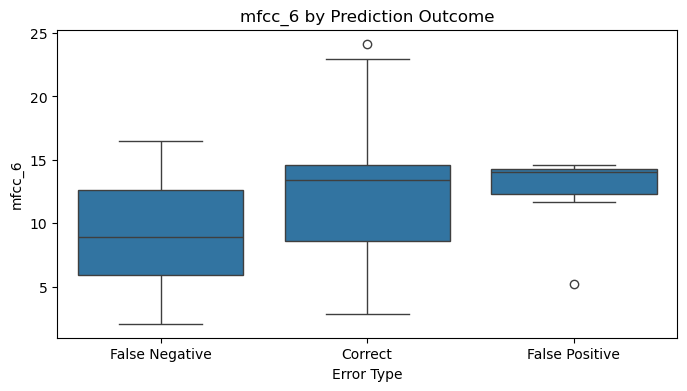

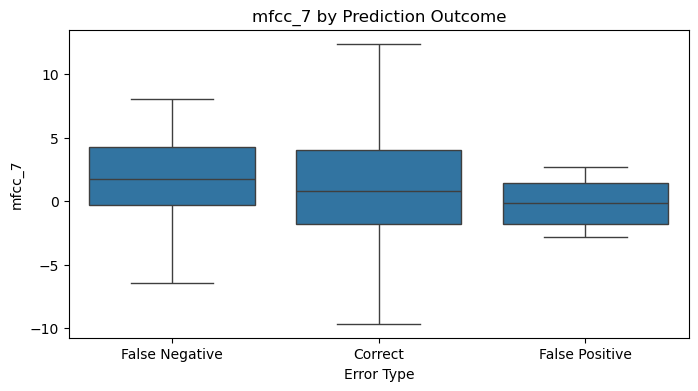

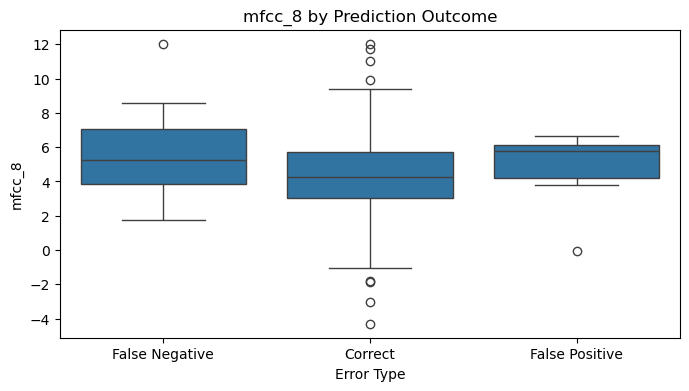

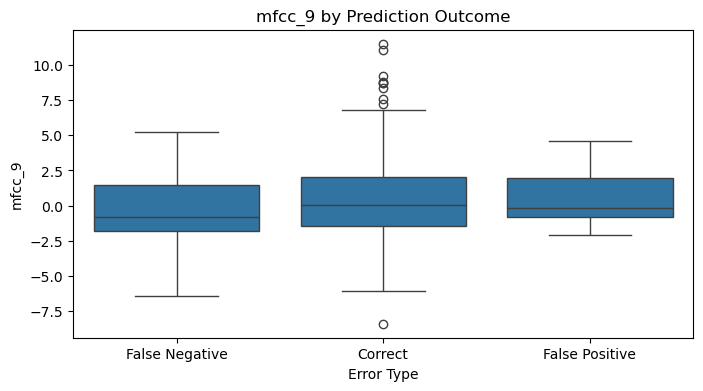

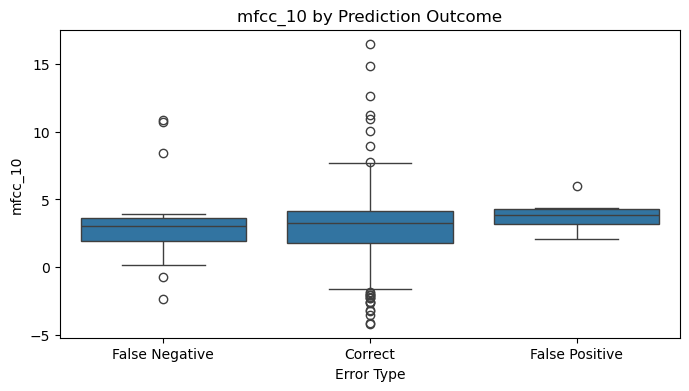

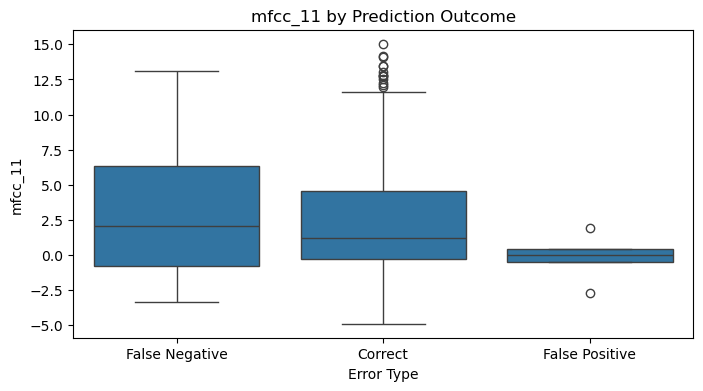

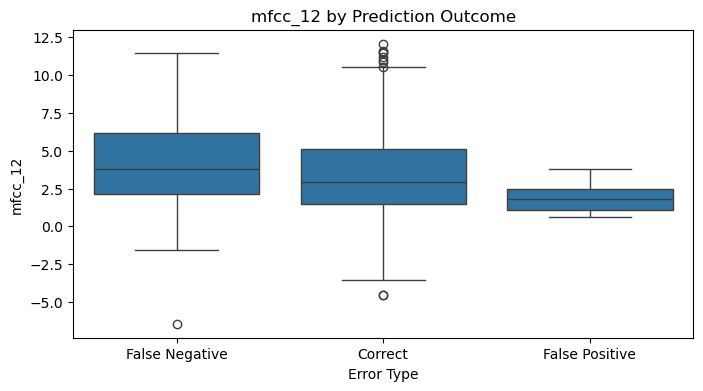

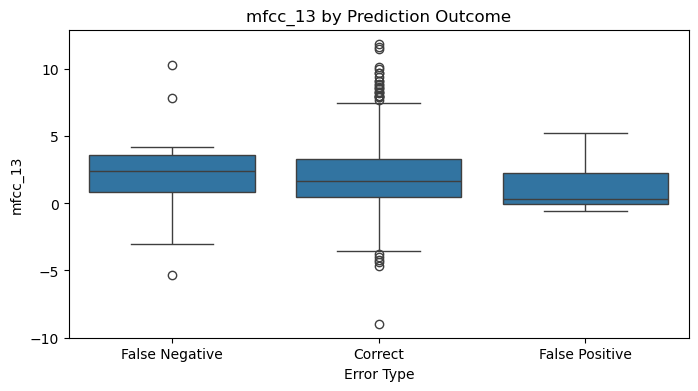

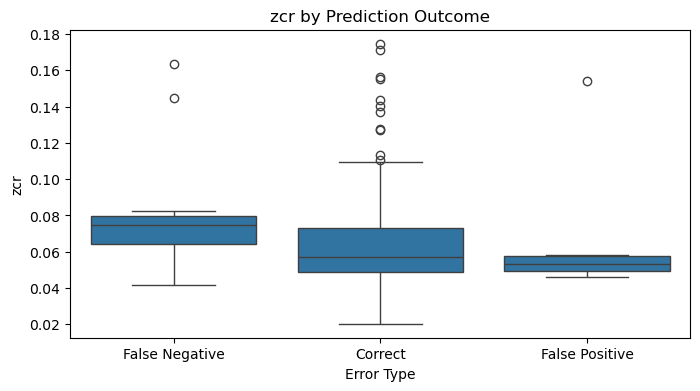

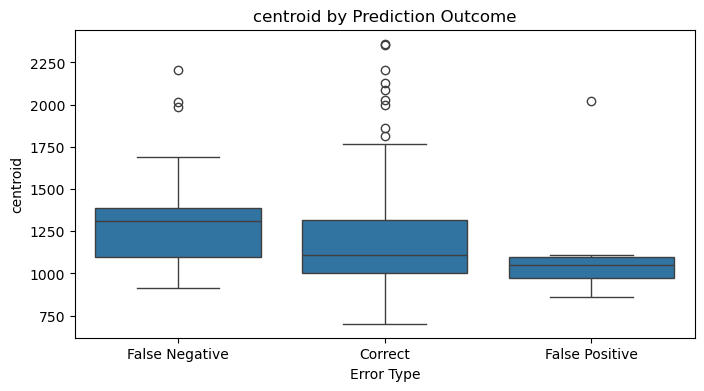

In [18]:
# Let's examine the misclassified observations.

X_test_with_labels = X_test_unscaled.copy()

X_test_with_labels['True Label'] = y_test
X_test_with_labels['Predicted Label'] = y_pred_rf_smote

false_positives = X_test_with_labels[(X_test_with_labels['True Label'] == 0) & (X_test_with_labels['Predicted Label'] == 1)]
false_negatives = X_test_with_labels[(X_test_with_labels['True Label'] == 1) & (X_test_with_labels['Predicted Label'] == 0)]

X_test_with_labels['Error Type'] = 'Correct'
X_test_with_labels.loc[false_positives.index, 'Error Type'] = 'False Positive'
X_test_with_labels.loc[false_negatives.index, 'Error Type'] = 'False Negative'

features_to_plot = list(X_test_unscaled.columns)

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Error Type', y=feature, data=X_test_with_labels)
    plt.title(f'{feature} by Prediction Outcome')
    plt.show()

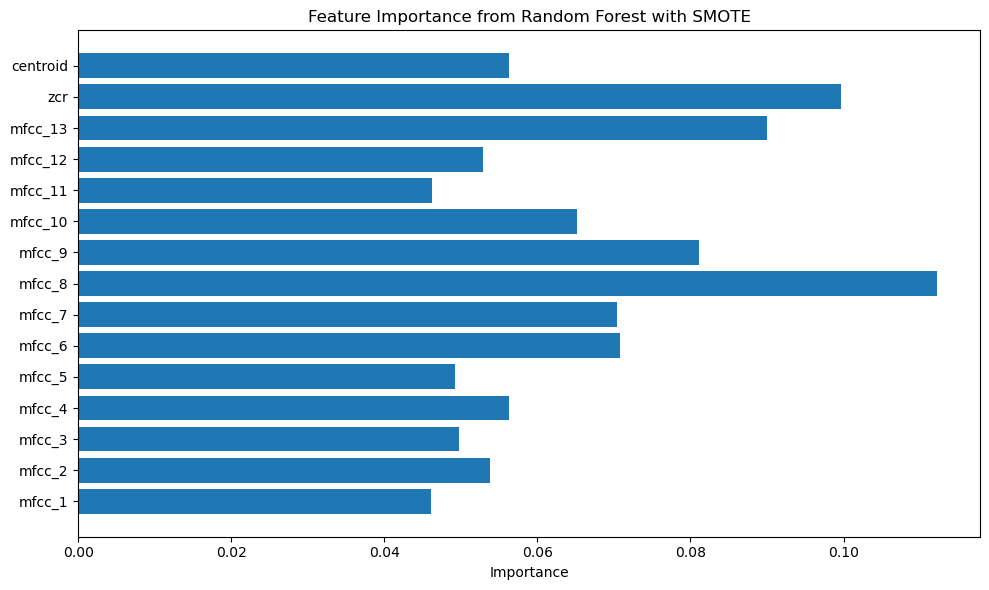

In [19]:
# Examine feature importance
importances = rf_smote.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest with SMOTE")
plt.tight_layout()
plt.show()

The previous Boxen plots as well as the model performance are suggestive that the included features successfully capture anomolies, at least for this particular fan. Given how well this model performed, additional features could not improve the model significantly.

In [20]:
# Here we will grab the data from a second fan
# This will be a test to determine how well this model works as a genereal model
# This is a demonstation about what can happen if you try to apply a model fit to a specific circustance to data from different circustances
base_dir2 = "./fan/id_04"
categories2 = ['normal', 'abnormal']

data2 = []

for label in categories2:
    folder = os.path.normpath(os.path.join(base_dir2, label))
    print(folder)
    for file_name in tqdm(os.listdir(folder), desc=f"Processing {label}"):
        if not file_name.endswith(".wav"):
            continue
        file_path = os.path.join(folder, file_name)
        try:                                              # Error could be bad file or bug
            features = extract_features(file_path)
            data2.append({
                'file': file_name,
                'label': 0 if label == 'normal' else 1,
                **{f'mfcc_{i+1}': val for i, val in enumerate(features[:13])},
                'zcr': features[13],
                'centroid': features[14],
                'sample_rate': features[15]
            })
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

df2 = pd.DataFrame(data2)
print(df2.head())

fan\id_04\normal


Processing normal: 100%|███████████████████████████████████████████████████████████| 1033/1033 [00:22<00:00, 45.20it/s]


fan\id_04\abnormal


Processing abnormal: 100%|███████████████████████████████████████████████████████████| 348/348 [00:07<00:00, 45.40it/s]


           file  label      mfcc_1      mfcc_2    mfcc_3     mfcc_4  \
0  00000000.wav      0 -348.593994  112.671341 -4.213779   8.480335   
1  00000001.wav      0 -344.548615  124.486534 -6.926779  22.483589   
2  00000002.wav      0 -315.063446   86.236282 -3.335989  21.818005   
3  00000003.wav      0 -347.059814  112.909409 -1.836970   8.959689   
4  00000004.wav      0 -341.485138  122.293282 -5.556899  22.651993   

      mfcc_5    mfcc_6    mfcc_7    mfcc_8    mfcc_9   mfcc_10   mfcc_11  \
0 -11.722754 -2.496118 -4.551630  4.078247 -0.003857 -1.260817  2.678916   
1  -7.915618  5.082470 -5.831834  3.142526 -0.081118  0.279864 -1.880551   
2 -10.647293  3.965642 -5.732403  3.416419  1.102853 -0.085508 -3.722545   
3 -11.316451 -3.213477 -4.088412  5.968449  2.670849 -3.165328 -4.888780   
4  -8.395997  4.307653 -6.558548  3.558956  0.470869  1.513373 -0.903016   

    mfcc_12   mfcc_13       zcr     centroid  sample_rate  
0  3.123898  2.164967  0.097494  1485.746411      16000.

Class distribution:
 label
0    1033
1     348
Name: count, dtype: int64


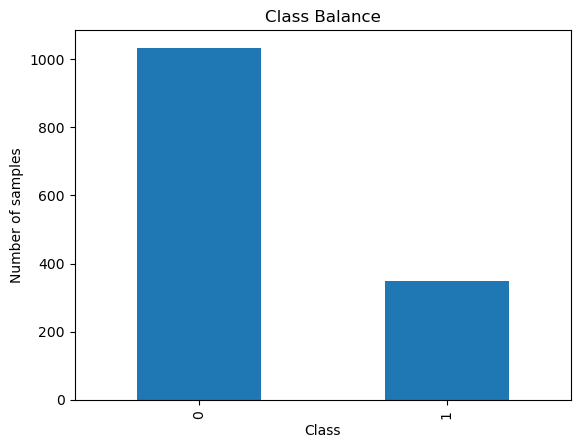

In [21]:
# Checking class balance, this could skew results if too many normal/abnormal even if the model poorly performs

class_counts = df2['label'].value_counts()
print("Class distribution:\n", class_counts)

class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

In [22]:
X2 = df2.drop(columns=['label', 'file', 'sample_rate'])
y2 = df2['label']

# Normalize features
X2_scaled = scaler.transform(X2)       #Have to use the same scaling as the other data to ensure the results are comparable

y2_pred_rf_smote = rf_smote.predict(X2_scaled)
y2_prob_rf_smote = rf_smote.predict_proba(X2_scaled)[:, 1]

results2 = []

results2.append(get_metrics("Random Forest SMOTE Fan 1", y_test, y_pred_rf_smote, y_prob_rf_smote))
results2.append(get_metrics("Random Forest SMOTE Fan 2", y2, y2_pred_rf_smote, y2_prob_rf_smote))

results2_df = pd.DataFrame(results2).set_index('Model').round(3)

results2_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Random Forest SMOTE Fan 1,0.915,0.914,0.780,0.842,0.947
Random Forest SMOTE Fan 2,0.760,0.614,0.124,0.206,0.691


The model performed poorly on the second fan data, as expected. The conditions of fan 2 were likely significantly differnt such that abnormal results were harder to detect based on the data from fan 1.

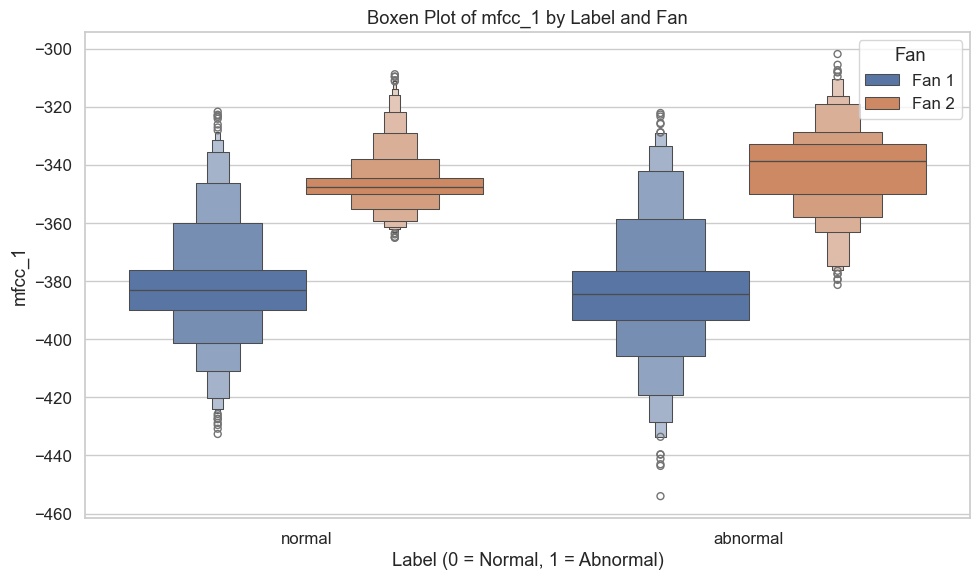

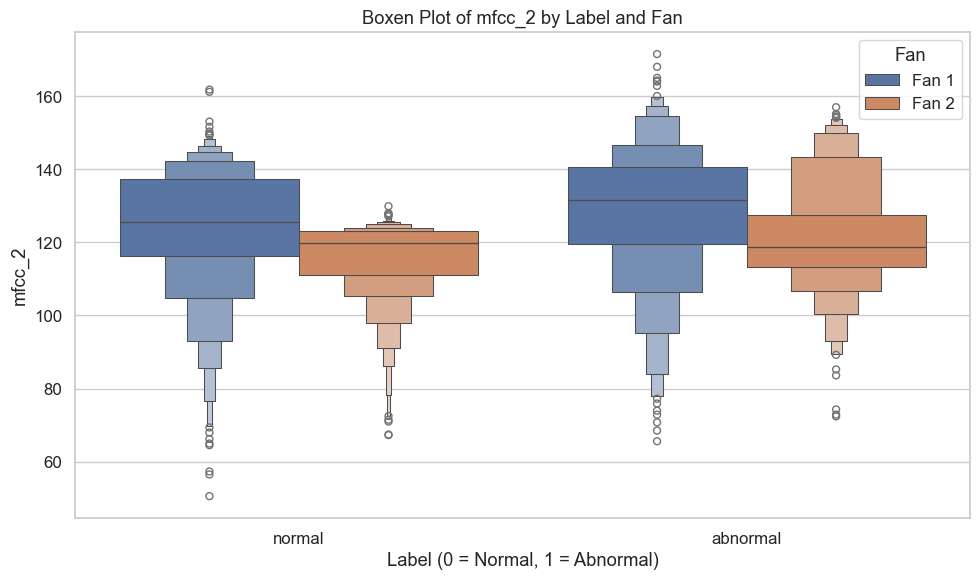

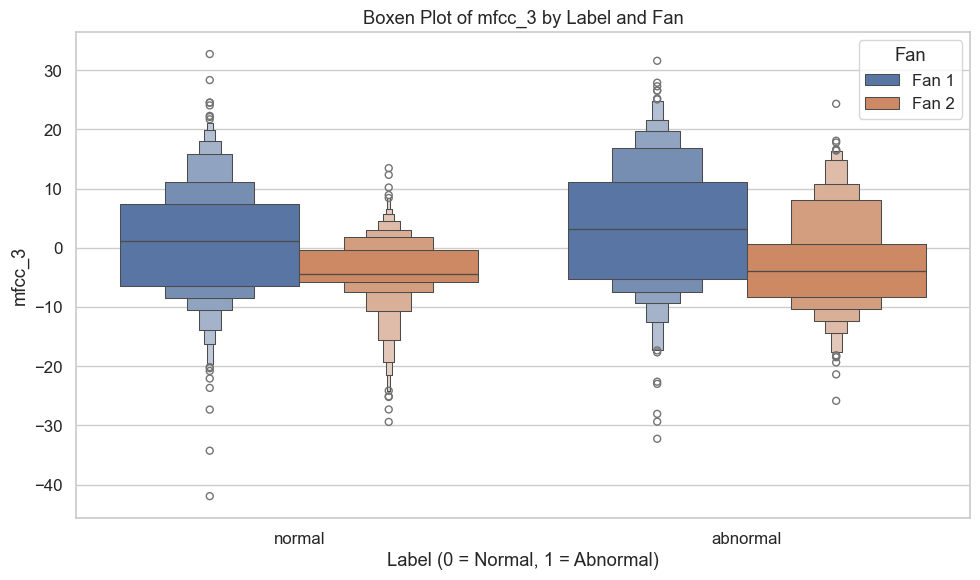

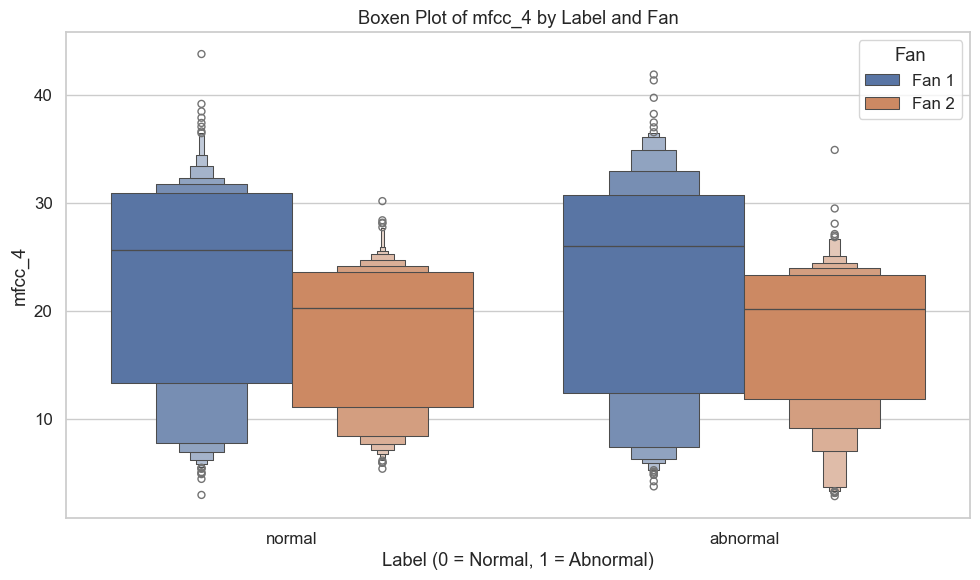

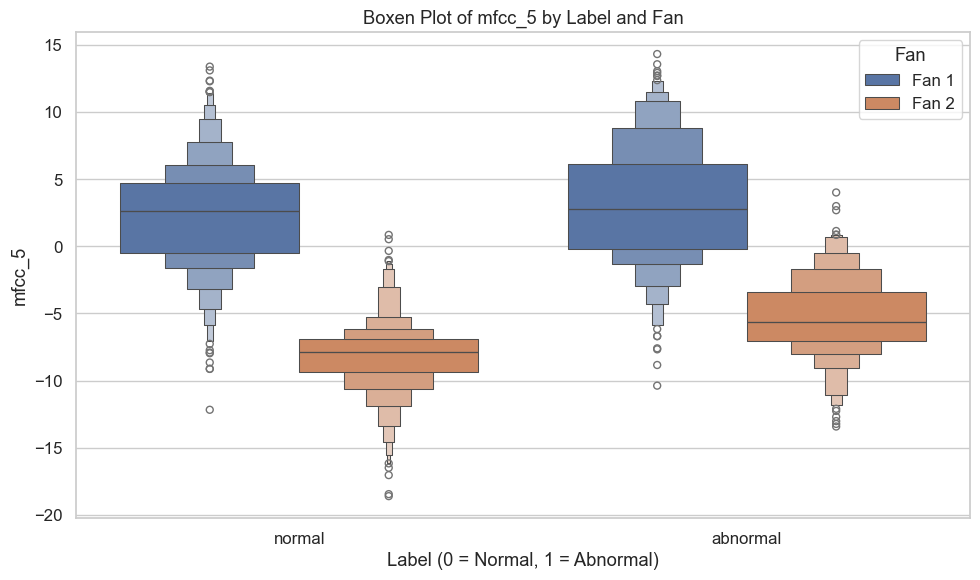

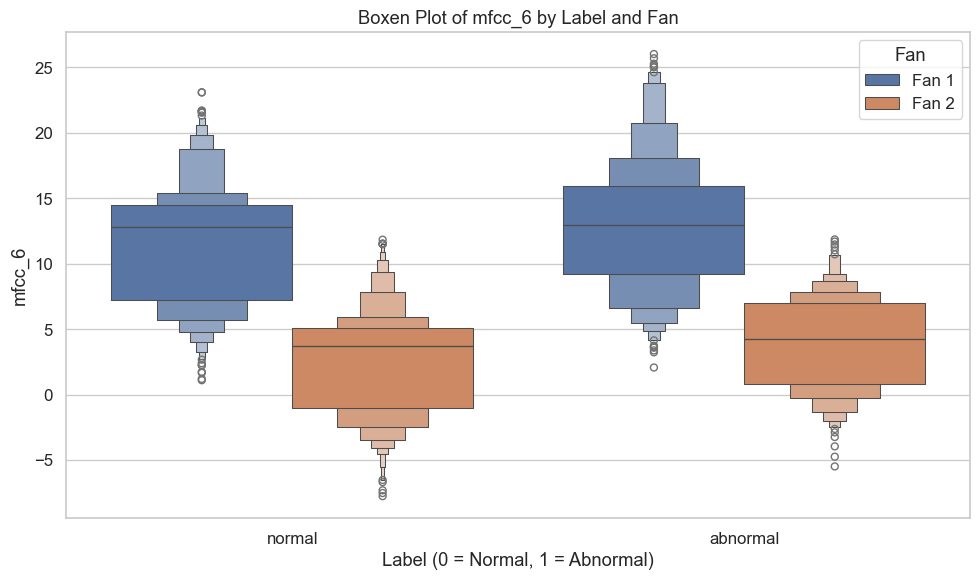

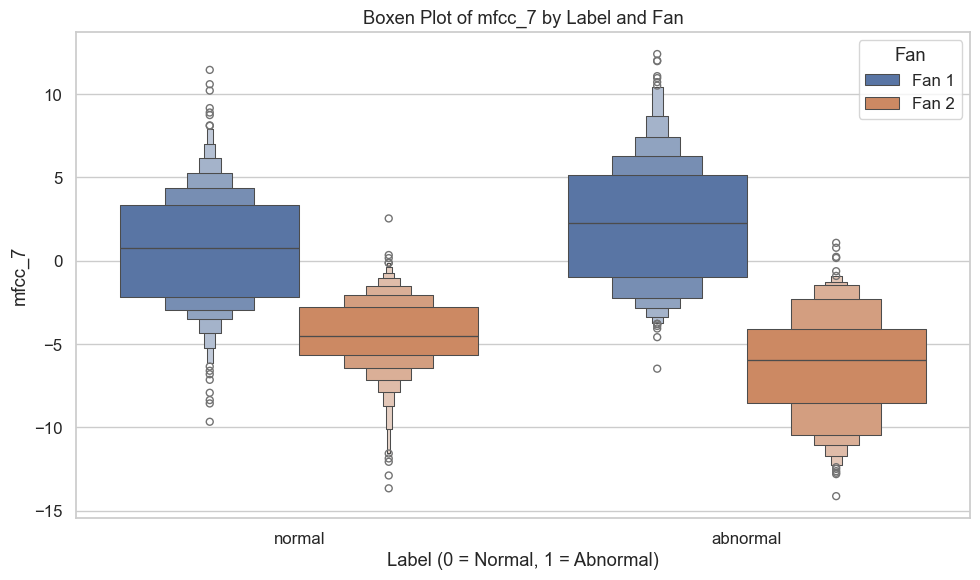

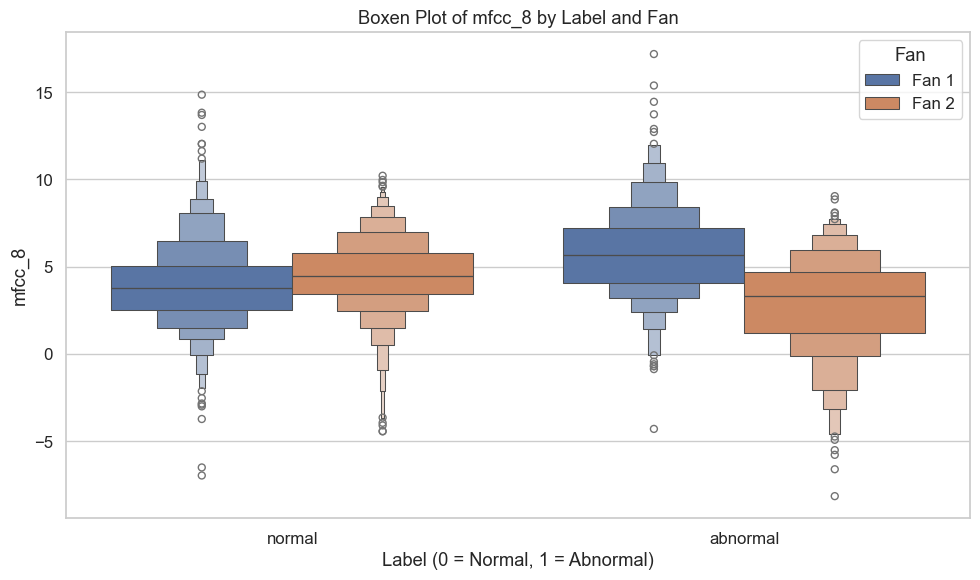

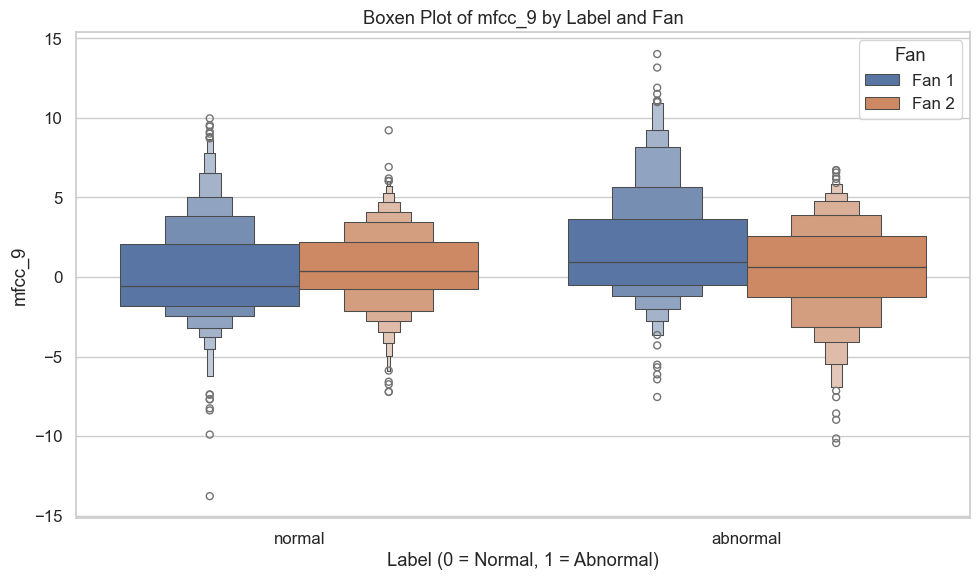

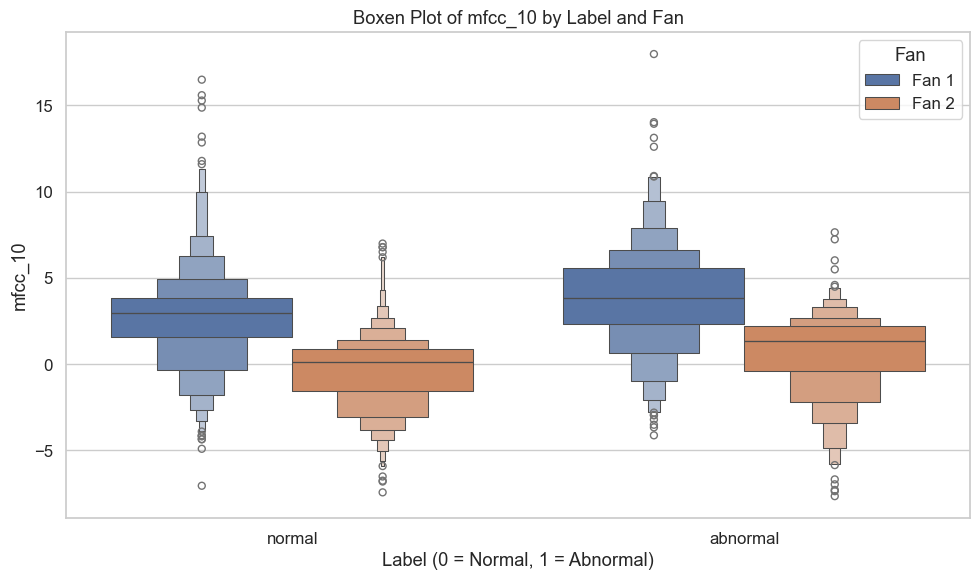

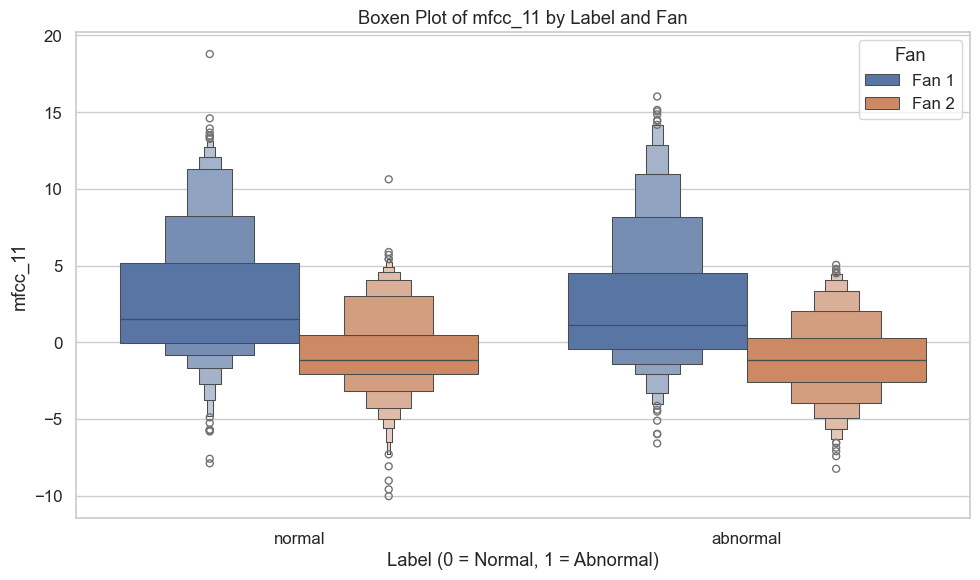

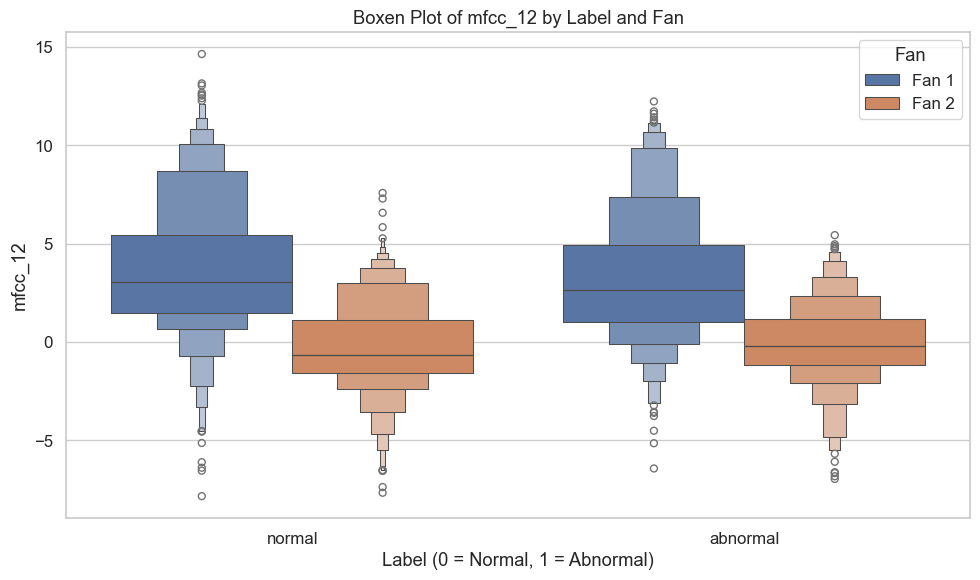

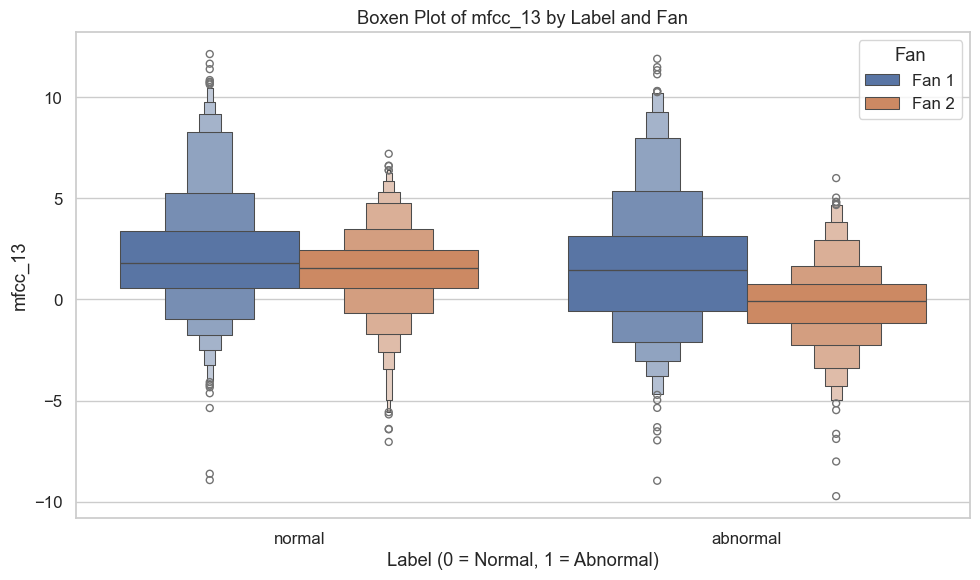

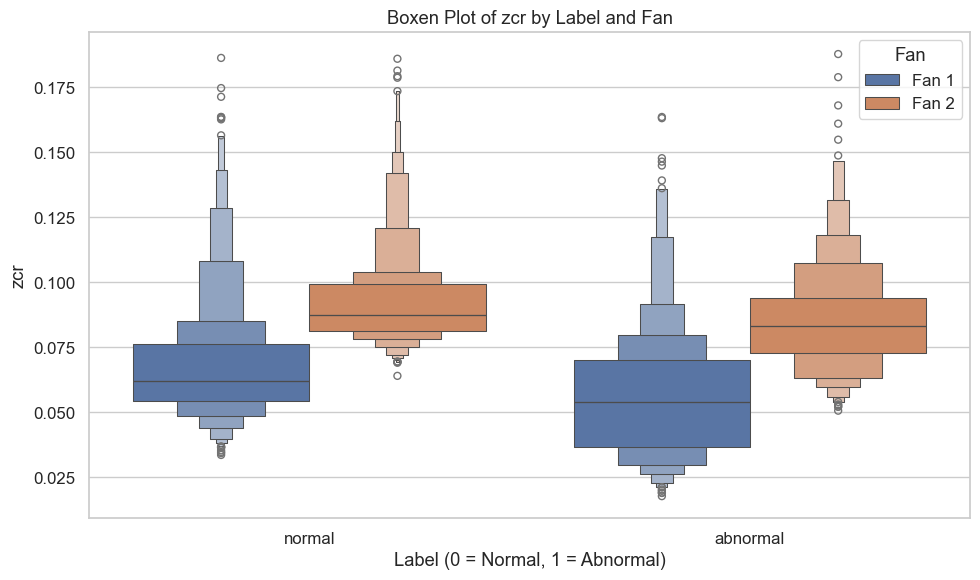

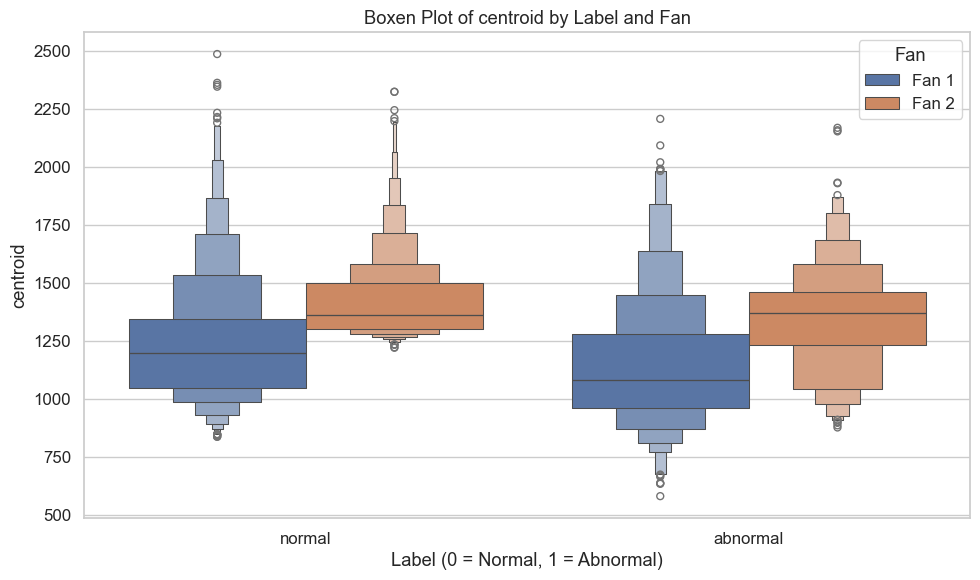

In [23]:
# Let's compare the features between the 2 fans and see if there is a clear distinction between fans
df['fan'] = 'Fan 1'
df2['fan'] = 'Fan 2'

df_combined = pd.concat([df, df2], ignore_index=True)
df_combined['label'] = df_combined['label'].apply(lambda x: 'normal' if x == 0 else 'abnormal')

feature_cols = [col for col in df.columns if col not in ['label', 'fan', 'file', 'sample_rate']]

sns.set(style="whitegrid", font_scale=1.1)

for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    sns.boxenplot(data=df_combined, x='label', y=feature, hue='fan')
    plt.title(f'Boxen Plot of {feature} by Label and Fan')
    plt.xlabel('Label (0 = Normal, 1 = Abnormal)')
    plt.ylabel(feature)
    plt.legend(title='Fan')
    plt.tight_layout()
    plt.show()

## Conclusion
We were able to develop a well performing model that performed greatly on fan 2. However, when applied to a second fan, the model performed poorly.

There are clear differnces between fan 1 and fan 2 features. This example illustrates why we must be careful when attempting to apply a model to new circustances. 

We can accurately build prediction models but if the underlying circustances change, these models could perform poorly.